In [1]:
import os
import pathlib
import sys
from ast import literal_eval
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from utilities.statistics_analyzer.blockchain import (
    get_swap_latencies_from_blockchain_output,
)


def add_gz_extension_if_exists(filepath: str | os.PathLike) -> pathlib.Path:
    """Check if filepath.gz exists and return that. Otherwise return filepath.

    If none of filepath.gz and filepath exist, throws a FileNotFoundError.
    The result is converted to an absolute pathlib.Path object.
    """
    abs_path = pathlib.Path(filepath).resolve()
    gz_path = abs_path.parent / (abs_path.name + ".gz")
    if gz_path.is_file():
        return gz_path
    if abs_path.is_file():
        return abs_path
    msg = f"Could not find {abs_path} or {gz_path}"
    raise FileNotFoundError(msg)


# Set up the seaborn style
latex_preamble = r"""
\renewcommand{\bfdefault}{sb}  % Semibold weight
"""
custom_params = {
    "grid.linestyle": "--",
    "text.usetex": True,
    "text.latex.preamble": latex_preamble,
    "font.family": "serif",
    "font.size": 16,
    "legend.title_fontsize": 12,
    "axes.linewidth": 1.5,
    "lines.linewidth": 3,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "lines.markersize": 8,
}
sns.set_theme(style="whitegrid", rc=custom_params)
sns.color_palette("tab10")
blues = sns.color_palette("ch:s=.25,rot=-.25")

### Plot 1 (ex Fig.6 in BRAIN24) - EXP 1
Data from experiment 1

In [2]:
def assign_rebal_mode(row):
    if (
        row["waterfall"] == 1
        and row["reverse_waterfall"] == 1
        and row["submarine_swaps"] == 1
    ):
        return "Full"
    elif row["waterfall"] == 1 and row["reverse_waterfall"] == 1:
        return "Rev"
    else:
        return "None"


# Define dataframe
exp_1_SH = pd.read_csv(add_gz_extension_if_exists("./results/exp-1/SH_PCN/results.csv"))
exp_1_SH["rebal_mode"] = exp_1_SH.apply(assign_rebal_mode, axis=1)

exp_1_SF = pd.read_csv(add_gz_extension_if_exists("./results/exp-1/SF_PCN/results.csv"))
exp_1_SF["rebal_mode"] = exp_1_SF.apply(assign_rebal_mode, axis=1)

/tmp/ipykernel_41191/1619591458.py:56: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-0.5, 1.1)
/tmp/ipykernel_41191/1619591458.py:56: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-0.5, 1.1)


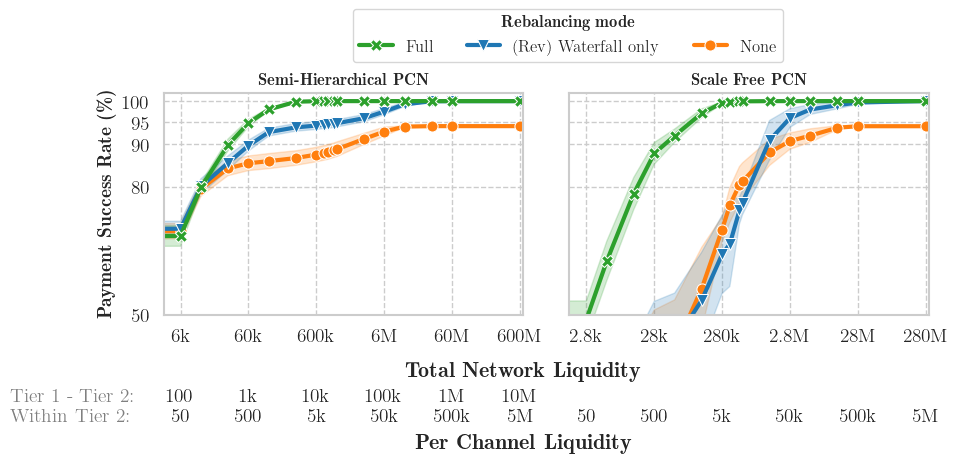

In [3]:
# Define the custom scale function
def forward(x):
    return np.exp(x**2)


# Apply the inverse of the transformation
def inverse(x):
    return np.log(x**2)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

SH_labels = [
    "6k\n\n\n100\n50",
    "60k\n\n\n1k\n500",
    "600k\n\n\n10k\n5k",
    "6M\n\n\n100k\n50k",
    "60M\n\n\n1M\n500k",
    "600M\n\n\n10M\n5M",
]

SF_labels = [
    "2.8k\n\n\n\n50",
    "28k\n\n\n\n500",
    "280k\n\n\n\n5k",
    "2.8M\n\n\n\n50k",
    "28M\n\n\n\n500k",
    "280M\n\n\n\n5M",
]


def plot_1(df, ax, custom_labels):
    custom_palette = {
        "Full": "tab:green",
        "Rev": "tab:blue",
        "None": "tab:orange",
    }

    sns.lineplot(
        data=df,
        x="capacity",
        y="success",
        hue="rebal_mode",
        marker="o",
        estimator="mean",
        palette=custom_palette,
        markers=["o", "v", "X"],
        style="rebal_mode",
        dashes=False,
        errorbar="sd",
        alpha=1,
        ax=ax,
    )
    ax.set_xscale("log")
    ax.set_xlim(-0.5, 1.1)
    major_ticks = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

    ax.set_xlabel("")
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(custom_labels)


plot_1(exp_1_SH, axes[0], SH_labels)
plot_1(exp_1_SF, axes[1], SF_labels)
axes[0].set_ylabel(r"\textbf{Payment Success Rate (\%)}")
axes[0].set_ylim(0.5, 1.02)
# axes[0].set_yscale("function", functions=(forward, inverse))

y_minor_ticks = [0.1, 0.5, 0.8, 0.9, 0.95, 1]
axes[0].yaxis.set_major_locator(ticker.FixedLocator(y_minor_ticks))
axes[0].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
)
axes[0].yaxis.set_minor_formatter(
    ticker.PercentFormatter(
        xmax=1,
        decimals=0,
    )
)

fig.text(0.5, 0.18, r"\textbf{Total Network Liquidity}", ha="center")
fig.text(0.5, 0, r"\textbf{Per Channel Liquidity}", ha="center")

fig.text(
    -0.07,
    0.07,
    "Tier 1 - Tier 2:\nWithin Tier 2:",
    ha="left",
    color="gray",
    fontsize=14,
)

axes[0].title.set_text(r"\textbf{Semi-Hierarchical PCN}")
axes[1].title.set_text(r"\textbf{Scale Free PCN}")

# Create a single legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()

labels = ["Full", "(Rev) Waterfall only", "None"]
order = [2, 1, 0]
fig.legend(
    handles=[handles[idx] for idx in order],
    labels=labels,
    title=r"\textbf{Rebalancing mode}",
    loc="upper center",
    bbox_to_anchor=(0.55, 1.12),
    ncol=3,
)
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.tight_layout()
plt.show()
fig.savefig(
    "plots/plot1.pdf",
    format="pdf",
    pad_inches=0,
    bbox_inches="tight",
)
plt.close(fig)

### Plot 2 - Cost
Data from experiment 1

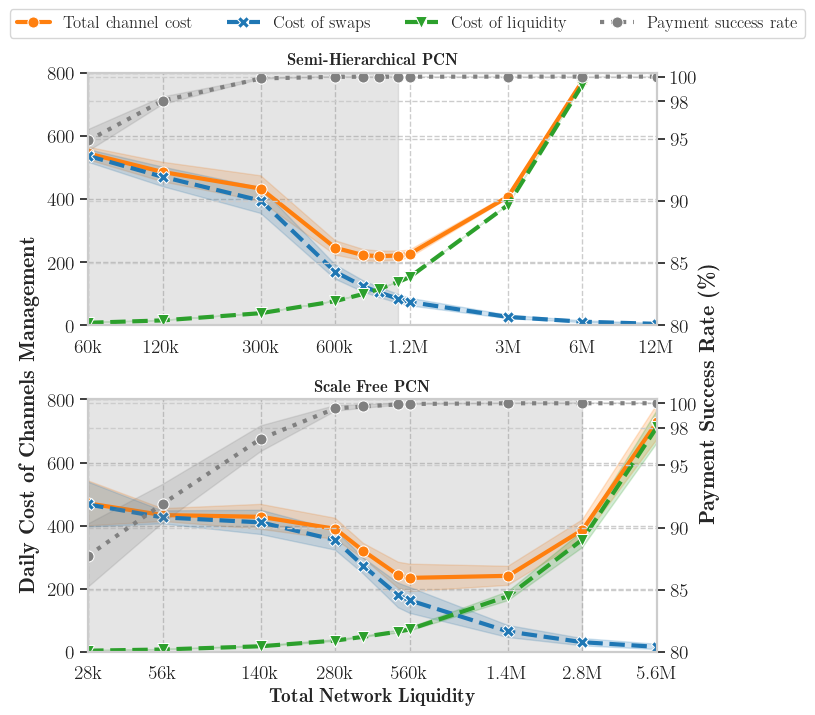

In [4]:
# Cost of locked liquidity
def cost_plot(df: pd.DataFrame, ax, xlabels, x_max):
    sns.lineplot(
        data=df[df["rebal_mode"] == "Full"],
        x="capacity",
        y="total_cost",
        marker="o",
        linestyle="-",
        color="tab:orange",
        errorbar="sd",
        estimator="mean",
        alpha=1,
        label="Total channel cost",
        ax=ax,
        legend=False,
    )
    p = sns.lineplot(
        data=df[df["rebal_mode"] == "Full"],
        x="capacity",
        y="cost_submarine_swaps",
        marker="X",
        linestyle="--",
        color="tab:blue",
        errorbar="sd",
        estimator="mean",
        alpha=1,
        label="Cost of swaps",
        ax=ax,
        legend=False,
    )
    p.axvspan(0.0001, x_max, color="grey", alpha=0.2)
    sns.lineplot(
        data=df[df["rebal_mode"] == "Full"],
        x="capacity",
        y="cost_wholesale_liquidity",
        marker="v",
        linestyle="--",
        color="tab:green",
        errorbar="sd",
        estimator="mean",
        alpha=1,
        label="Cost of liquidity",
        ax=ax,
        legend=False,
    )
    ax2 = ax.twinx()
    sns.lineplot(
        data=df[df["rebal_mode"] == "Full"],
        ax=ax2,
        x="capacity",
        y="success",
        marker="o",
        linestyle=":",
        color="gray",
        errorbar="sd",
        estimator="mean",
        alpha=1,
        legend=False,
        label="Payment success rate",
    )
    ax.set_ylim(0, 800)
    y_major_ticks = [0, 200, 400, 600, 800]
    y_custom_labels = ["0", "200", "400", "600", "800"]
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_major_ticks))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_custom_labels))
    ax2.set_ylim(0.8, 1.003)

    y_minor_ticks = [0.1, 0.5, 0.8, 0.85, 0.9, 0.95, 0.98, 1]
    # y_minor_ticks = [0.975, 1]
    ax2.yaxis.set_major_locator(ticker.FixedLocator(y_minor_ticks))
    ax2.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
    )
    ax2.yaxis.set_minor_formatter(
        ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
    )
    ax.set_ylabel("")
    ax2.set_ylabel("")

    ax.set_xscale("log")
    ax.set_xlim(0.0001, 0.02)
    major_ticks = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]

    ax.set_xticks(major_ticks)
    ax.set_xticklabels(xlabels)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    return h1 + h2, l1 + l2


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
SH_labels = ["60k", "120k", "300k", "600k", "1.2M", "3M", "6M", "12M"]
SF_labels = ["28k", "56k", "140k", "280k", "560k", "1.4M", "2.8M", "5.6M"]

handles, labels = cost_plot(
    exp_1_SH[exp_1_SH["capacity"] >= 0.0001], axes[0], SH_labels, 0.0018
)
cost_plot(exp_1_SF[exp_1_SF["capacity"] >= 0.0001], axes[1], SF_labels, 0.01)

axes[0].title.set_text(r"\textbf{Semi-Hierarchical PCN}")
axes[1].title.set_text(r"\textbf{Scale Free PCN}")

axes[0].set_xlabel("")
axes[1].set_xlabel(r"\textbf{Total Network Liquidity}")


fig.text(
    0.01, 0.2, r"\textbf{Daily Cost of Channels Management}", ha="center", rotation=90
)
fig.text(0.98, 0.3, r"\textbf{Payment Success Rate (\%)}", ha="center", rotation=90)


fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.55, 1.04), ncol=4)
# axes[0].get_legend().remove()
# axes[1].get_legend().remove()

plt.tight_layout()
plt.show()
fig.savefig(
    "./plots/plot2.pdf",
    format="pdf",
    pad_inches=0,
    bbox_inches="tight",
)
plt.close(fig)

### Plot 3 - ECDF Time
Data from experiment 1

/tmp/ipykernel_41191/915588177.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f) for f in payments_output_files),
/tmp/ipykernel_41191/915588177.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f) for f in payments_output_files),
/tmp/ipykernel_41191/915588177.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_only["time"] = tx_only["end_time"] - tx_only["start_time"]
/tmp/ipykernel_41191/915588177.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f) for f in payments_output_files),
/tmp/ipykernel_41191/915588177.py:44: Se

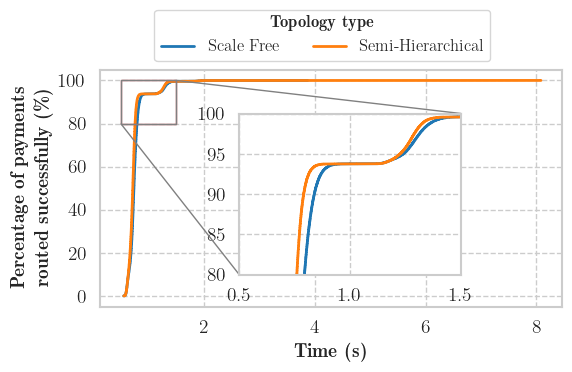

In [5]:
def _ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y


def read_time_data(topology_type, folder_name):
    # Define the root directory
    root_dir = Path(f"results/exp-1/{topology_type}/{folder_name}")

    # Initialize a list to hold the DataFrames
    times = []
    ecdfs = []

    # Loop through each subdirectory in the root directory
    for sub_dir in sorted(root_dir.iterdir(), key=lambda d: d.name):
        # Check if it is a directory
        if sub_dir.is_dir():
            # proceed only if either:
            # - all the files in sub_dir have extension .csv
            # - all the files in sub_dir have extension .csv.gz
            # Do not allow mixed extensions.
            payments_output_files_gz = sorted(sub_dir.glob("payments_output_*.csv.gz"))
            payments_output_files_csv = sorted(sub_dir.glob("payments_output_*.csv"))
            if (
                len(payments_output_files_gz) != 0
                and len(payments_output_files_csv) != 0
            ):
                msg = f"Directory {sub_dir} contains both .csv and .csv.gz files. This is not supported"
                raise RuntimeError(msg)
            if len(payments_output_files_gz) != 0:
                payments_output_files = payments_output_files_gz
            else:
                payments_output_files = payments_output_files_csv
            payments_df = pd.concat(
                (pd.read_csv(f) for f in payments_output_files),
                ignore_index=True,
            ).sort_values(by=["id"])
            tx_only = payments_df[payments_df["type"] == 0]
            tx_only["time"] = tx_only["end_time"] - tx_only["start_time"]
            times.append(tx_only["time"] / 1000)

    min_nb_payments = min(len(time) for time in times)
    times = [time[:min_nb_payments] for time in times]
    ecdfs = [_ecdf(time) for time in times]

    return ecdfs


def plot3(ax):
    SH_time_ecdf = read_time_data("SH_PCN", "0.0018-FULL")
    SF_time_ecdf = read_time_data("SF_PCN", "0.01-FULL")

    SH_mean_x = np.mean([row[0] for row in SH_time_ecdf], axis=0)
    SH_mean_y = np.mean([row[1] for row in SH_time_ecdf], axis=0)

    SF_mean_x = np.mean([row[0] for row in SF_time_ecdf], axis=0)
    SF_mean_y = np.mean([row[1] for row in SF_time_ecdf], axis=0)

    # Add a zoomed-in inset plot
    from matplotlib.patches import Rectangle
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    ax.step(
        SF_mean_x,
        SF_mean_y,
        where="post",
        color="tab:blue",
        linewidth=2,
        label="Scale Free",
        zorder=1,
    )
    ax.step(
        SH_mean_x,
        SH_mean_y,
        where="post",
        color="tab:orange",
        linewidth=2,
        label="Semi-Hierarchical",
        zorder=1,
    )
    # Create the inset axes
    axins = inset_axes(
        ax,
        width="60%",
        height="80%",
        bbox_to_anchor=(0, 0, 0.8, 0.85),
        bbox_transform=ax.transAxes,
    )
    axins.set_xlim(0.5, 1.5)  # Set x-axis limits for zoomed-in view
    axins.set_ylim(0.8, 1)  # Ensure the y-axis is consistent with ECDF

    # Add the ECDF steps to the inset axes
    axins.step(
        SF_mean_x, SF_mean_y, where="post", color="tab:blue", linewidth=2, zorder=1
    )
    axins.step(
        SH_mean_x, SH_mean_y, where="post", color="tab:orange", linewidth=2, zorder=1
    )
    axins.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
    )
    rect = Rectangle((0.5, 0.8), 1, 0.2, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

    ax.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
    )
    ax.set_xlabel(r"\textbf{Time (s)}")
    ax.set_ylabel(
        r"\begin{center}\textbf{Percentage of payments}\\\textbf{routed successfully (\%)}\end{center}"
    )
    ax.legend(title=r"\textbf{Topology type}", bbox_to_anchor=(0.1, 1), ncol=2)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot3(ax)
plt.tight_layout()
plt.show()
fig.savefig("./plots/plot3.pdf", format="pdf", pad_inches=0, bbox_inches="tight")
plt.close(fig)

### Plot 4 - ECDF Swap

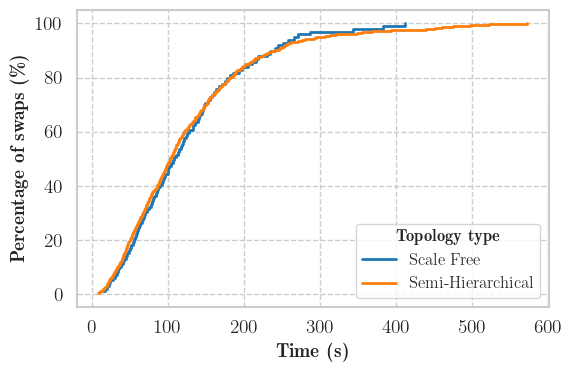

In [6]:
# 0.0018
def read_swap_data(topology_type, folder_name):
    # Define the root directory
    root_dir = Path(f"results/exp-1/{topology_type}/{folder_name}")

    # Initialize a list to hold the DataFrames
    latencies = []
    ecdfs = []

    # Loop through each subdirectory in the root directory
    for sub_dir in sorted(root_dir.iterdir(), key=lambda d: d.name):
        # Check if it is a directory
        if sub_dir.is_dir():
            # Define the path to the results.csv file
            blockchain_csv_file = add_gz_extension_if_exists(
                sub_dir / "blockchain_output_0.csv"
            )
            # Check if the blockchain csv file exists
            if blockchain_csv_file.exists():
                # Read the swap latencies
                latencies.append(
                    get_swap_latencies_from_blockchain_output(blockchain_csv_file)
                    / 1000
                )

    min_nb_latencies = min(len(sub_array) for sub_array in latencies)
    latencies = [latency[:min_nb_latencies] for latency in latencies]
    ecdfs = [_ecdf(latency) for latency in latencies]

    return ecdfs


def plot4(ax):
    SH_swap_ecdf = read_swap_data("SH_PCN", "0.0018-FULL")
    SF_swap_ecdf = read_swap_data("SF_PCN", "0.01-FULL")

    SH_mean_x = np.mean([row[0] for row in SH_swap_ecdf], axis=0)
    SH_mean_y = np.mean([row[1] for row in SH_swap_ecdf], axis=0)

    SF_mean_x = np.mean([row[0] for row in SF_swap_ecdf], axis=0)
    SF_mean_y = np.mean([row[1] for row in SF_swap_ecdf], axis=0)

    ax.step(
        SF_mean_x,
        SF_mean_y,
        where="post",
        color="tab:blue",
        linewidth=2,
        label="Scale Free",
        zorder=1,
    )
    ax.step(
        SH_mean_x,
        SH_mean_y,
        where="post",
        color="tab:orange",
        linewidth=2,
        label="Semi-Hierarchical",
        zorder=1,
    )
    ax.yaxis.set_major_formatter(
        ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True)
    )
    ax.set_xlabel(r"\textbf{Time (s)}")
    ax.set_ylabel(r"\begin{center}\textbf{Percentage of swaps (\%)}\end{center}")
    plt.legend(title=r"\textbf{Topology type}")


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot4(ax)
plt.tight_layout()
plt.show()
fig.savefig("./plots/plot4.pdf", format="pdf", pad_inches=0, bbox_inches="tight")
plt.close(fig)

### Plot 5 - ECDF Hop
Data from experiment 1

3.976037735849057
4.208018867924529


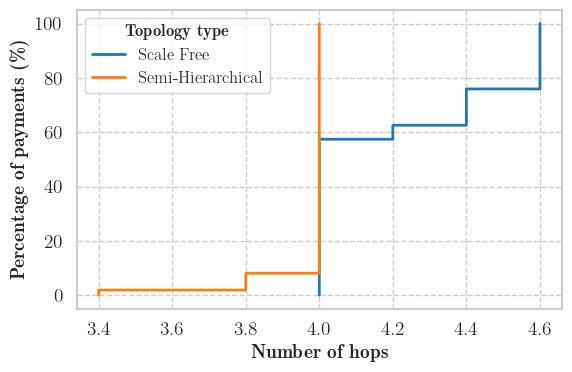

In [7]:
filtered_exp_3_SH = exp_1_SH[
    (exp_1_SH["rebal_mode"] == "Full") & (exp_1_SH["capacity"] == 0.0018)
]
filtered_exp_3_SF = exp_1_SF[
    (exp_1_SF["rebal_mode"] == "Full") & (exp_1_SF["capacity"] == 0.01)
]


def hops_ecdf(hops_data):
    hops_data = literal_eval(hops_data)
    hops = list(hops_data.keys())
    totals = [hops_data[hop]["Total"] for hop in hops]
    result = np.concatenate(
        [np.full(total, int(hop)) for total, hop in zip(totals, hops)]
    )
    result = result[:106000]
    sampled_result = result[::50]
    return _ecdf(sampled_result)


SH_hops_ecdf = [
    hops_ecdf(row["route_length_distr"]) for _, row in filtered_exp_3_SH.iterrows()
]
SF_hops_ecdf = [
    hops_ecdf(row["route_length_distr"]) for _, row in filtered_exp_3_SF.iterrows()
]

SH_mean_x = np.mean([row[0] for row in SH_hops_ecdf], axis=0)
SH_mean_y = np.mean([row[1] for row in SH_hops_ecdf], axis=0)

SF_mean_x = np.mean([row[0] for row in SF_hops_ecdf], axis=0)
SF_mean_y = np.mean([row[1] for row in SF_hops_ecdf], axis=0)

print(np.mean(SH_mean_x))
print(np.mean(SF_mean_x))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.step(
    SF_mean_x,
    SF_mean_y,
    where="post",
    color="tab:blue",
    linewidth=2,
    label="Scale Free",
    zorder=1,
)
plt.step(
    SH_mean_x,
    SH_mean_y,
    where="post",
    color="tab:orange",
    linewidth=2,
    label=r"Semi-Hierarchical",
    zorder=1,
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0, is_latex=True))
ax.set_ylabel(r"\begin{center}\textbf{Percentage of payments (\%)}\end{center}")
ax.set_xlabel(r"\textbf{Number of hops}")
plt.legend(title=r"\textbf{Topology type}")
plt.tight_layout()
plt.show()
fig.savefig("./plots/plot5.pdf", format="pdf", pad_inches=0, bbox_inches="tight")
plt.close(fig)

### Plot 6 (ex Fig.8 in BRAIN24)
Data from experiment 2

In [8]:
def generate_plot_6_data(df: pd.DataFrame):
    # Generate the submarine_swaps_per_minute
    window_size = 30
    submarine_swaps_per_minute = pd.DataFrame(
        [
            {
                "minute": int(minute),
                "number": number,
                "capacity": row["capacity"],
                "seed": row["seed"],
            }
            for _, row in df.iterrows()
            for minute, number in literal_eval(
                row["submarine_swaps_per_minute"]
            ).items()
        ]
    ).sort_values(by=["capacity", "seed", "minute"])

    submarine_swaps_per_minute["tx_smooth"] = (
        submarine_swaps_per_minute.groupby(["capacity", "seed"])["number"]
        .rolling(window=window_size, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    # Generate the deposits_per_minute
    deposits_per_minute_c_01 = pd.DataFrame(
        [
            {
                "minute": int(minute),
                "number": number,
                "capacity": row["capacity"],
                "seed": row["seed"],
            }
            for _, row in df[df["capacity"] == 0.01].iterrows()
            for minute, number in literal_eval(row["deposits_per_minute"]).items()
        ]
    ).sort_values(by=["minute", "seed"])
    deposits_per_minute_c_01["tx_smooth"] = (
        deposits_per_minute_c_01.groupby("seed")["number"]
        .rolling(window=window_size, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    # Generate the withdrawals_per_minute
    withdrawals_per_minute_c_01 = pd.DataFrame(
        [
            {
                "minute": int(minute),
                "number": number,
                "capacity": row["capacity"],
                "seed": row["seed"],
            }
            for _, row in df[df["capacity"] == 0.01].iterrows()
            for minute, number in literal_eval(row["withdrawals_per_minute"]).items()
        ]
    ).sort_values(by=["minute", "seed"])
    withdrawals_per_minute_c_01["tx_smooth"] = (
        withdrawals_per_minute_c_01.groupby("seed")["number"]
        .rolling(window=window_size, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    return (
        submarine_swaps_per_minute,
        deposits_per_minute_c_01,
        withdrawals_per_minute_c_01,
    )

In [9]:
# Define dataframe
exp_2_SH = pd.read_csv(add_gz_extension_if_exists("./results/exp-2/SH_PCN/results.csv"))
exp_2_SF = pd.read_csv(add_gz_extension_if_exists("./results/exp-2/SF_PCN/results.csv"))

# Generate data for plot
submarine_swaps_per_min_SH, deposits_per_min_c_01_SH, withdrawals_per_min_c_01_SH = (
    generate_plot_6_data(exp_2_SH[exp_2_SH["capacity"] != 0.001])
)
submarine_swaps_per_min_SF, deposits_per_min_c_01_SF, withdrawals_per_min_c_01_SF = (
    generate_plot_6_data(exp_2_SF[exp_2_SF["capacity"] != 0.001])
)

/tmp/ipykernel_41191/1726257513.py:32: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_41191/1726257513.py:81: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(


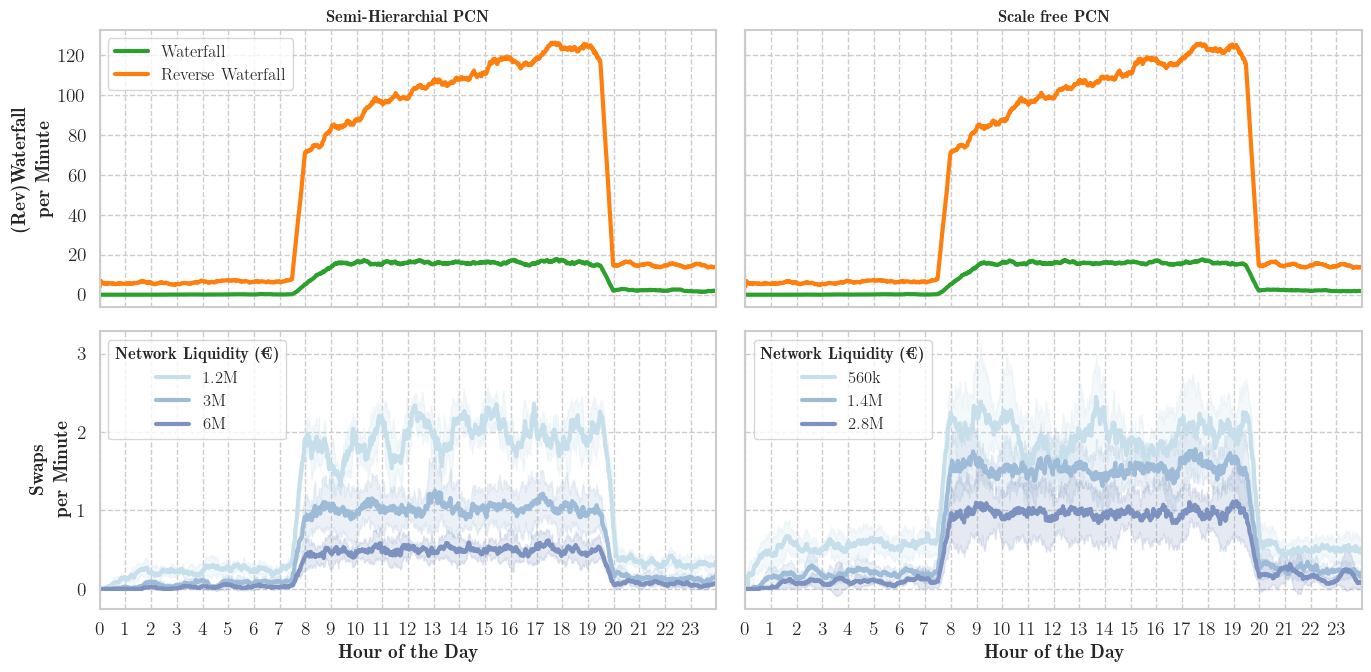

In [10]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex="col", sharey="row")

# SH-PCN
# First subplot (0,0)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    data=deposits_per_min_c_01_SH,
    estimator="mean",
    errorbar="sd",
    label="Waterfall",
    color="tab:green",
    ax=axes[0, 0],
)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    data=withdrawals_per_min_c_01_SH,
    estimator="mean",
    errorbar="sd",
    color="tab:orange",
    label="Reverse Waterfall",
    ax=axes[0, 0],
)
axes[0, 0].title.set_text(r"\textbf{Semi-Hierarchial PCN}")
axes[0, 0].set_ylabel(
    r"\begin{center}\textbf{(Rev)Waterfall}\\\textbf{per Minute}\end{center}"
)

# Second subplot (1,0)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    hue="capacity",
    data=submarine_swaps_per_min_SH,
    palette=blues,
    estimator="mean",
    errorbar="sd",
    ax=axes[1, 0],
)
axes[1, 0].set_xticks(list(range(0, 1440, 60)))
axes[1, 0].set_xticklabels([str(n) for n in range(24)])
axes[1, 0].set_xlim(0, 1440)
axes[1, 0].set_xlabel(r"\textbf{Hour of the Day}")
axes[1, 0].set_ylabel(r"\begin{center}\textbf{Swaps}\\\textbf{per Minute}\end{center}")

SH_legend_labels = ["1.2M", "3M", "6M"]
SH_handles, SH_labels = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(
    title=r"\textbf{Network Liquidity (€)}", handles=SH_handles, labels=SH_legend_labels
)


# SF-PCN
# Third subplot (0,1)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    data=deposits_per_min_c_01_SF,
    estimator="mean",
    errorbar="sd",
    label="Waterfall",
    color="tab:green",
    ax=axes[0, 1],
)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    data=withdrawals_per_min_c_01_SF,
    estimator="mean",
    errorbar="sd",
    color="tab:orange",
    label="Reverse Waterfall",
    ax=axes[0, 1],
)
axes[0, 1].title.set_text(r"\textbf{Scale free PCN}")
axes[0, 1].get_legend().remove()

# Fourth subplot (1,1)
sns.lineplot(
    x="minute",
    y="tx_smooth",
    hue="capacity",
    data=submarine_swaps_per_min_SF,
    palette=blues,
    estimator="mean",
    errorbar="sd",
    ax=axes[1, 1],
)

SF_legend_labels = ["560k", "1.4M", "2.8M"]
SF_handles, SF_labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(
    title=r"\textbf{Network Liquidity (€)}", handles=SF_handles, labels=SF_legend_labels
)
axes[1, 1].set_xticks(list(range(0, 1440, 60)))
axes[1, 1].set_xticklabels([str(n) for n in range(24)])
axes[1, 1].set_xlim(0, 1440)
axes[1, 1].set_xlabel(r"\textbf{Hour of the Day}")
plt.subplots_adjust(wspace=0.07, hspace=0.1)

plt.tight_layout()
plt.show()
fig.savefig("./plots/plot6.pdf", format="pdf", pad_inches=0.05, bbox_inches="tight")
plt.close(fig)

### Plot 7 (NEW)
Data from experiment 3

In [11]:
def read_experiment_3(topology_type):
    # Define the root directory
    root_dir = Path("results")

    # Initialize a list to hold the DataFrames
    dataframes = []

    # Loop through each subdirectory in the root directory
    for sub_dir in root_dir.iterdir():
        # Check if the subdirectory name starts with 'exp-3' and is a directory
        if sub_dir.is_dir() and sub_dir.name.startswith("exp-3"):
            # Define the path to the results.csv file
            csv_file = add_gz_extension_if_exists(
                sub_dir / topology_type / "results.csv"
            )
            # Check if the results.csv file exists
            if csv_file.exists():
                # Read the CSV file into a DataFrame
                df = pd.read_csv(csv_file)
                # Extract the sub-index from the directory name
                sub_index = sub_dir.name.split("-")[-1]
                sub_index = int(sub_index[1:])
                # Add the sub-index as a new column
                df["experiment_sub_index"] = sub_index
                # Append the DataFrame to the list
                dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df


# Define dataframe
exp_3_SH = read_experiment_3("SH_PCN")
exp_3_SF = read_experiment_3("SF_PCN")

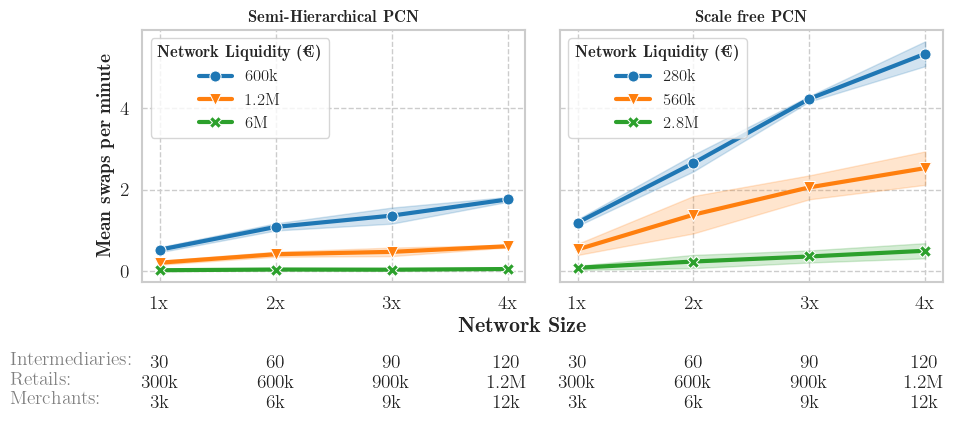

In [12]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True, sharex=True)

# SH-PCN
# First subplot (0,0)
sns.lineplot(
    x="experiment_sub_index",
    y="mean_submarine_swaps_per_minute",
    data=exp_3_SH,
    estimator="mean",
    errorbar="sd",
    dashes=False,
    hue="capacity",
    palette="tab10",
    markers=["o", "v", "X"],
    style="capacity",
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel(r"\textbf{Mean swaps per minute}")
axes[0].title.set_text(r"\textbf{Semi-Hierarchical PCN}")


# SF-PCN
# Second subplot (0,1)
sns.lineplot(
    x="experiment_sub_index",
    y="mean_submarine_swaps_per_minute",
    data=exp_3_SF,
    estimator="mean",
    errorbar="sd",
    dashes=False,
    hue="capacity",
    palette="tab10",
    markers=["o", "v", "X"],
    style="capacity",
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].title.set_text(r"\textbf{Scale free PCN}")

fig.text(0.5, 0.23, r"\textbf{Network Size}", ha="center")

# Create legend
handles, labels = axes[0].get_legend_handles_labels()
SH_labels = ["600k", "1.2M", "6M"]
SF_labels = ["280k", "560k", "2.8M"]
axes[0].legend(
    handles=handles,
    labels=SH_labels,
    title=r"\textbf{Network Liquidity (€)}",
    loc="upper left",
)
axes[1].legend(
    handles=handles,
    labels=SF_labels,
    title=r"\textbf{Network Liquidity (€)}",
    loc="upper left",
)


custom_labels = [
    "1x\n\n\n30\n300k\n3k",
    "2x\n\n\n60\n600k\n6k",
    "3x\n\n\n90\n900k\n9k",
    "4x\n\n\n120\n1.2M\n12k",
]
axes[0].set_xticks(range(1, 5))
axes[0].set_xticklabels(custom_labels)
axes[1].set_xticks(range(1, 5))
axes[1].set_xticklabels(custom_labels)

fig.text(
    -0.07,
    0.07,
    "Intermediaries:\nRetails:\nMerchants:",
    ha="left",
    color="gray",
    fontsize=14,
)

plt.tight_layout()
plt.show()
fig.savefig("./plots/plot7.pdf", format="pdf", pad_inches=0.05, bbox_inches="tight")
plt.close(fig)